# Chest X-Ray Medical Diagnosis with Deep Learning

## Imports

In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

I0000 00:00:1740501412.851315     854 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740501413.174111     854 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740501413.176163     854 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.17.0')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [5]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.IMAGES_DIR)

datasets/images-small


In [7]:
TRAIN_CSV = Path(cfg.DATASET_DIRS.TRAIN_CSV)
VALID_CSV = Path(cfg.DATASET_DIRS.VALID_CSV)
TEST_CSV = Path(cfg.DATASET_DIRS.TEST_CSV)

## Load the Datasets
[ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.

### Loading the Data

In [8]:
train_df = pd.read_csv(f"{TRAIN_CSV}")
valid_df = pd.read_csv(f"{VALID_CSV}")

test_df = pd.read_csv(f"{TEST_CSV}")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

### Total Labels

In [10]:
column_names = list(train_df.columns)
labels = column_names[1:]
labels.remove('PatientId')
labels, len(labels)

(['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'],
 14)

### Unique Check

In [11]:
train_df.PatientId.count(),train_df.PatientId.nunique()

(1000, 928)

### Dataset Inbalance Check

In [12]:
sorted_df = train_df[labels].sum().sort_values()
sorted_df

Hernia                  2
Pneumonia              10
Emphysema              13
Fibrosis               14
Edema                  16
Cardiomegaly           20
Pleural_Thickening     21
Consolidation          33
Pneumothorax           38
Mass                   45
Nodule                 54
Atelectasis           106
Effusion              128
Infiltration          175
dtype: int64

## Data Visualization

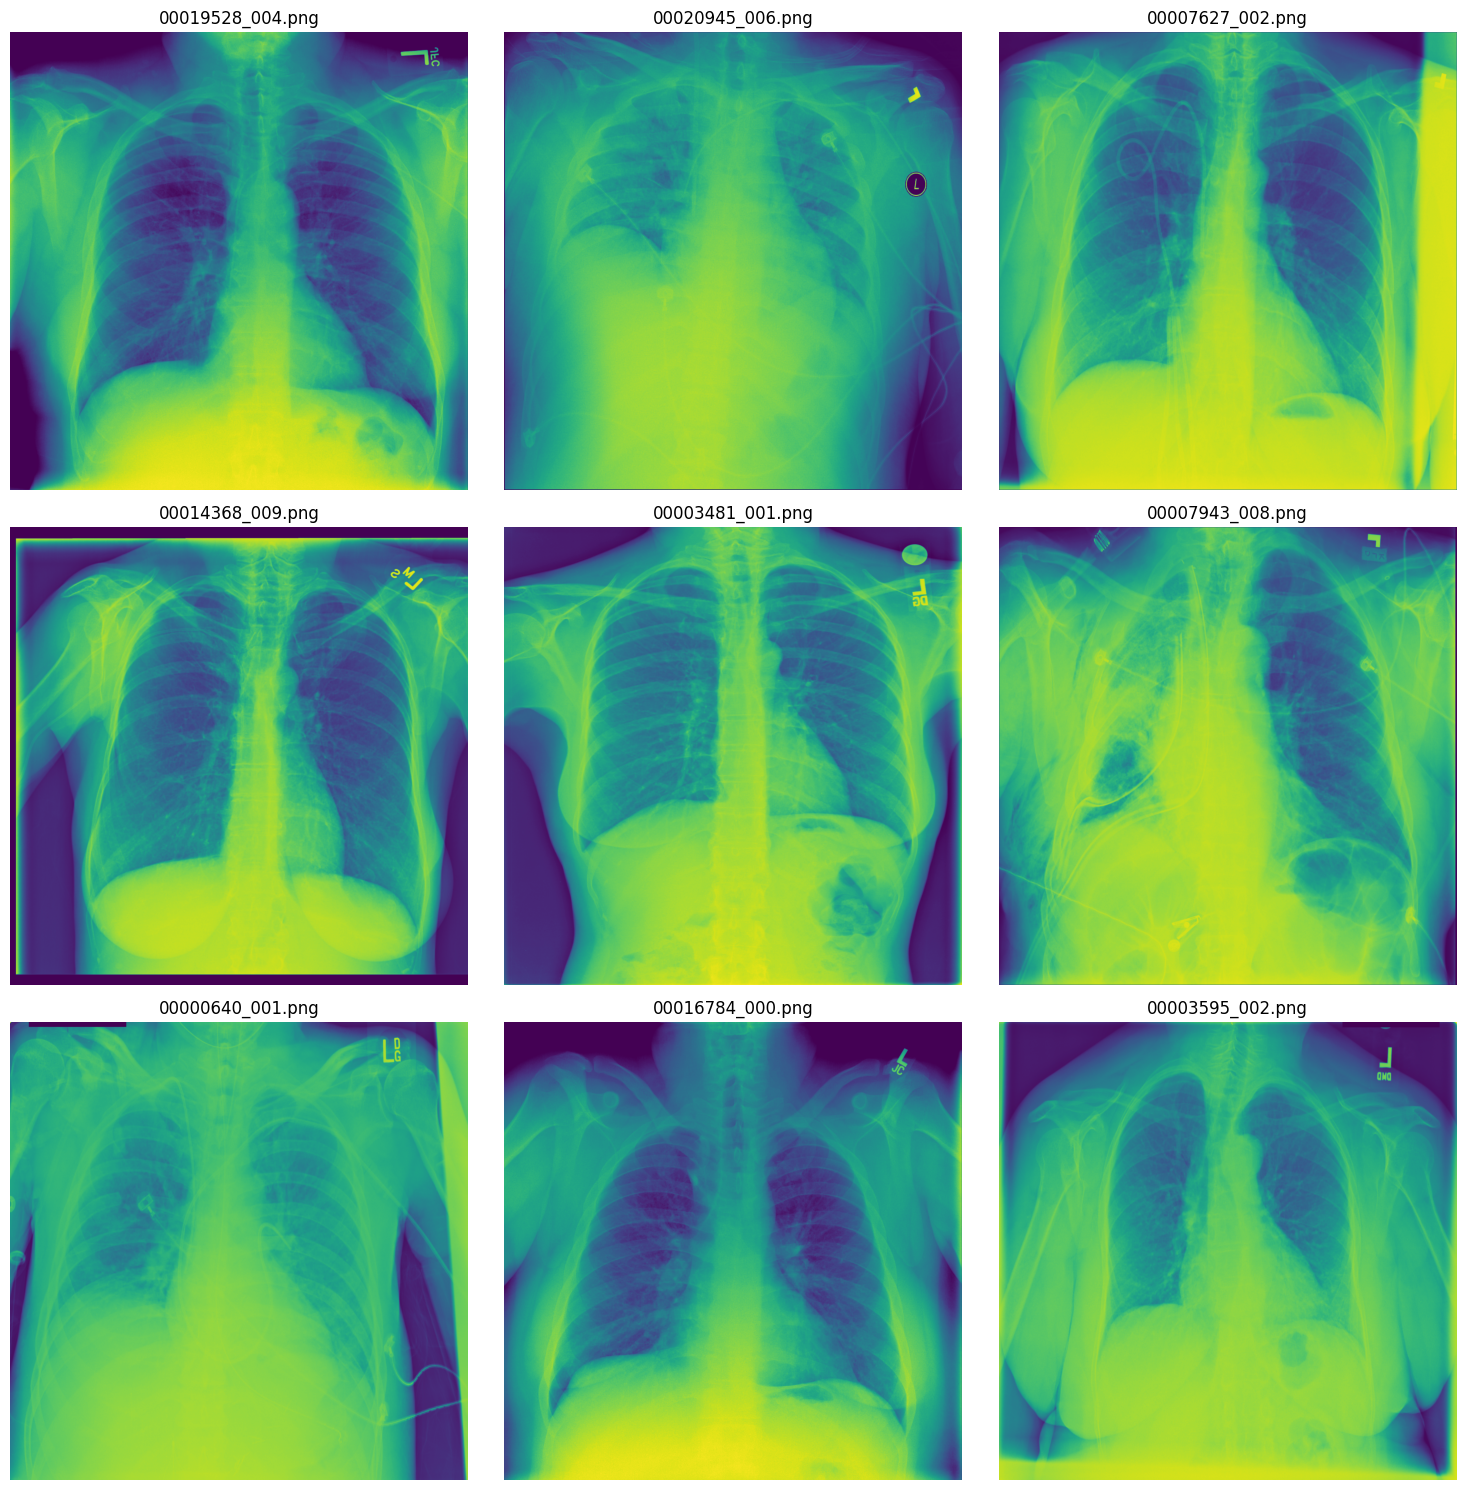

In [13]:
images = train_df.Image.values
IMAGE_NUM = 9
random_images = [np.random.choice(images) for _ in range(IMAGE_NUM)]

plt.figure(figsize=(15, 15))

for i in range(IMAGE_NUM):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(f"{cfg.DATASET_DIRS.IMAGES_DIR}/{random_images[i]}")
    plt.imshow(img)
    plt.axis("off")
    plt.title(random_images[i])
    
plt.tight_layout()
plt.show()

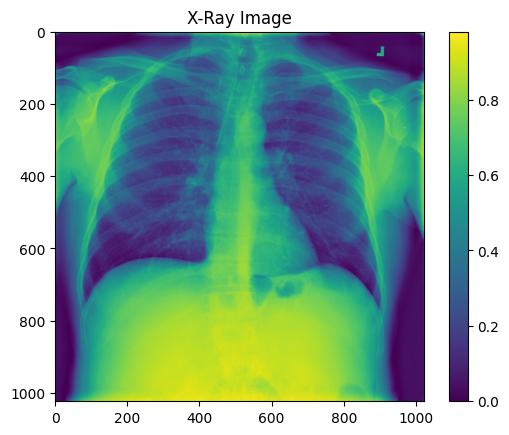

In [20]:
sample_image = train_df.Image[0]
img = plt.imread(f"{cfg.DATASET_DIRS.IMAGES_DIR}/{sample_image}")
plt.imshow(img)
plt.title('X-Ray Image')
plt.colorbar()

In [22]:
img.min(),img.max(), img.mean(),img.std()

(0.0, 0.98039216, 0.47961414, 0.275735)